# Feature Engineering

This notebook creates a unified feature set that can be applied consistently across both the 5k and 2k datasets. The engineered features emphasize operational signals that are reliably available in both datasets and remove dependencies on label-specific or 5k-exclusive fields. This prepares the data for cross-dataset modeling and pseudolabeling.

In [1]:

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

pd.set_option('display.max_columns', None)

# LOAD CLEAN DATASETS

clean_data_path = Path("../data/clean")
data_path = Path("../data/raw")
clean_5kp = pd.read_csv(clean_data_path /'5kp_clean.csv')
clean_2k = pd.read_csv(clean_data_path /'2k_clean.csv')
df_activity_ref = pd.read_csv(data_path / "Activity_Reference.csv")

# Convert 2k features to match 5k structure

In [2]:
# Create working copy
df_2k_processed = clean_2k.copy()

# Convert units (seconds to minutes)
df_2k_processed['duration_minutes'] = df_2k_processed['duration_sec'] / 60
df_2k_processed['wait_time_minutes'] = df_2k_processed['wait_time_sec'] / 60

print(f"Converted duration_sec → duration_minutes")
print(f"Converted wait_time_sec → wait_time_minutes")

# Rename columns for consistency
df_2k_processed = df_2k_processed.rename(columns={
    'event_nr': 'event_num_in_case',
    'activity': 'activity_name',
    'hour': 'hour_of_day',
    'sla_breach': 'sla_breached'
})

# Calculate handoff_count_so_far for 2k

print("\nCalculating handoff_count_so_far for 2k")

def calculate_handoffs(df):
    """
    Count cumulative handoffs (resource changes) per case
    """
    df = df.sort_values(['case_id', 'timestamp']).copy()
    
    # Detect when resource changes within a case
    df['resource_changed'] = (
        df.groupby('case_id')['resource']
        .shift(1) != df['resource']
    ).astype(int)
    
    # First event in each case is not a handoff
    df.loc[df.groupby('case_id').head(1).index, 'resource_changed'] = 0
    
    # Cumulative sum of handoffs per case
    df['handoff_count_so_far'] = df.groupby('case_id')['resource_changed'].cumsum()
    
    df = df.drop('resource_changed', axis=1)
    
    return df

df_2k_processed = calculate_handoffs(df_2k_processed)

print(f"  Average handoffs in 2k: {df_2k_processed['handoff_count_so_far'].mean():.2f}")
print(f"  Average handoffs in 5k: {clean_5kp['handoff_count_so_far'].mean():.2f}")

Converted duration_sec → duration_minutes
Converted wait_time_sec → wait_time_minutes

Calculating handoff_count_so_far for 2k
  Average handoffs in 2k: 3.10
  Average handoffs in 5k: 2.42


In [3]:
#Identify which activities are in reference table

activities_in_ref = set(df_activity_ref['activity_name'].unique())
activities_5k = set(clean_5kp['activity_name'].unique())
activities_2k = set(df_2k_processed['activity_name'].unique())

matched_2k = activities_2k.intersection(activities_in_ref)
unmatched_2k = activities_2k - activities_in_ref

print(f"\n2k Activities IN reference table: {len(matched_2k)}")
print(f"2k Activities NOT in reference table: {len(unmatched_2k)}")

# Calculate expected durations for unmatched activities

# Calculate median duration for each activity in 2k
activity_stats_2k = df_2k_processed.groupby('activity_name')['duration_minutes'].agg([
    ('expected_duration_minutes', 'median'),
    ('std_duration', 'std'),
    ('count', 'count')
]).reset_index()

print("\nActivity statistics from 2k data:")
print(activity_stats_2k.to_string(index=False))

# Create comprehensive expected duration lookup

# Start with reference table
expected_duration_lookup = df_activity_ref[['activity_name', 'expected_duration_minutes']].copy()
expected_duration_lookup['source'] = 'reference_table'

# Add expectations for unmatched activities
for activity in unmatched_2k:
    expected = activity_stats_2k[
        activity_stats_2k['activity_name'] == activity
    ]['expected_duration_minutes'].values[0]
    
    new_row = pd.DataFrame({
        'activity_name': [activity],
        'expected_duration_minutes': [expected],
        'source': ['data_driven']
    })
    expected_duration_lookup = pd.concat([expected_duration_lookup, new_row], ignore_index=True)

print("\nComplete expected duration lookup:")
print(expected_duration_lookup.to_string(index=False))

# Save lookup table

processed_data_path = Path("../data/processed")
expected_duration_lookup.to_csv(processed_data_path/'expected_duration_lookup.csv', index=False)
print("\nSaved: data/processed/expected_duration_lookup.csv")

# For 5k: Should already have it, but verify
if 'expected_duration_minutes' not in clean_5kp.columns:
    clean_5kp = clean_5kp.merge(
        expected_duration_lookup[['activity_name', 'expected_duration_minutes']],
        on='activity_name',
        how='left'
    )
    print("Added expected_duration_minutes to 5k")
else:
    print("5k already has expected_duration_minutes")

# For 2k: Add from lookup
df_2k_processed = df_2k_processed.merge(
    expected_duration_lookup[['activity_name', 'expected_duration_minutes', 'source']],
    on='activity_name',
    how='left',
    suffixes=('', '_lookup')
)

# Rename source column to be clear
df_2k_processed = df_2k_processed.rename(columns={'source': 'expected_duration_source'})

print(f"Added expected_duration_minutes to 2k")

# Check coverage
missing_expected = df_2k_processed['expected_duration_minutes'].isna().sum()
print(f"\nEvents missing expected_duration in 2k: {missing_expected}/{len(df_2k_processed)}")

if missing_expected > 0:
    print(df_2k_processed[df_2k_processed['expected_duration_minutes'].isna()]['activity_name'].unique())



2k Activities IN reference table: 3
2k Activities NOT in reference table: 5

Activity statistics from 2k data:
   activity_name  expected_duration_minutes  std_duration  count
Classify Request                   0.616667      0.547348    256
    Close Ticket                   0.650000      0.629357    255
     Enrich Data                   1.100000      0.826655    217
 Fulfill Request                   1.533333      0.813054    255
 Manual Approval                   2.991667      2.463150    210
 Notify Customer                   0.600000      0.628321    255
   Quality Check                   2.050000      1.254625    296
 Receive Request                   0.633333      0.538101    256

Complete expected duration lookup:
            activity_name  expected_duration_minutes          source
          Receive Request                  10.000000 reference_table
         Validate Request                  30.000000 reference_table
Approve Budget (optional)                  90.000000 referen

In [4]:
# Calculate variance_to_expected

def calculate_variance(df):
    """
    Calculate variance_to_expected = (actual - expected) / expected
    """
    df = df.copy()
    
    # Avoid division by zero
    mask = df['expected_duration_minutes'] > 0
    
    df.loc[mask, 'variance_to_expected'] = (
        (df.loc[mask, 'duration_minutes'] - df.loc[mask, 'expected_duration_minutes']) / 
        df.loc[mask, 'expected_duration_minutes']
    )
    
    # For zero expected duration, set variance to 0
    df.loc[~mask, 'variance_to_expected'] = 0
    
    return df

df_2k_processed = calculate_variance(df_2k_processed)

print(f"\n2k Variance Statistics:")
print(f"  Mean: {df_2k_processed['variance_to_expected'].mean():.3f}")
print(f"  Median: {df_2k_processed['variance_to_expected'].median():.3f}")
print(f"  Std: {df_2k_processed['variance_to_expected'].std():.3f}")
print(f"  Min: {df_2k_processed['variance_to_expected'].min():.3f}")
print(f"  Max: {df_2k_processed['variance_to_expected'].max():.3f}")

print(f"\n5k Variance Statistics (for comparison):")
print(f"  Mean: {clean_5kp['variance_to_expected'].mean():.3f}")
print(f"  Median: {clean_5kp['variance_to_expected'].median():.3f}")
print(f"  Std: {clean_5kp['variance_to_expected'].std():.3f}")




2k Variance Statistics:
  Mean: -0.242
  Median: -0.444
  Std: 0.860
  Min: -0.989
  Max: 5.889

5k Variance Statistics (for comparison):
  Mean: 0.353
  Median: 0.230
  Std: 0.558


# Proxy Feature Engineering

In [5]:
def calculate_concurrent_cases(df):
    """
    For each event, count how many other cases were active at that time
    Active = case started but not completed
    """
    df = df.sort_values('timestamp').copy()
    
    # Get case start and end times
    case_times = df.groupby('case_id')['timestamp'].agg(['min', 'max']).reset_index()
    case_times.columns = ['case_id', 'case_start', 'case_end']
    
    concurrent_counts = []
    
    for idx, row in df.iterrows():
        event_time = row['timestamp']
        event_case = row['case_id']
        
        # Count other active cases (excluding this case)
        concurrent = case_times[
            (case_times['case_id'] != event_case) &
            (case_times['case_start'] <= event_time) &
            (case_times['case_end'] >= event_time)
        ].shape[0]
        
        concurrent_counts.append(concurrent)
    
    df['concurrent_case_count'] = concurrent_counts
    
    return df


df_2k_processed = calculate_concurrent_cases(df_2k_processed)

print(f"\nCalculated concurrent_case_count")
print(f"  Mean: {df_2k_processed['concurrent_case_count'].mean():.2f}")
print(f"  Median: {df_2k_processed['concurrent_case_count'].median():.0f}")
print(f"  Max: {df_2k_processed['concurrent_case_count'].max():.0f}")


# Proxy for system_load_index_0to1

def calculate_system_load_proxy(df, window=10):
    """
    Calculate rolling average of wait_time, normalized to 0-1
    """
    df = df.sort_values('timestamp').copy()
    
    # Calculate rolling mean
    df['rolling_wait_time'] = df['wait_time_minutes'].rolling(
        window=window, 
        min_periods=1
    ).mean()
    
    # Normalize to 0-1
    min_val = df['rolling_wait_time'].min()
    max_val = df['rolling_wait_time'].max()
    
    if max_val > min_val:
        df['estimated_system_load'] = (df['rolling_wait_time'] - min_val) / (max_val - min_val)
    else:
        df['estimated_system_load'] = 0.5  # Default if no variance
    
    return df

df_2k_processed = calculate_system_load_proxy(df_2k_processed)

print(f"Calculated estimated_system_load")
print(f"  Mean: {df_2k_processed['estimated_system_load'].mean():.3f}")
print(f"  Median: {df_2k_processed['estimated_system_load'].median():.3f}")
print(f"  Range: [{df_2k_processed['estimated_system_load'].min():.3f}, {df_2k_processed['estimated_system_load'].max():.3f}]")





Calculated concurrent_case_count
  Mean: 0.05
  Median: 0
  Max: 1
Calculated estimated_system_load
  Mean: 0.379
  Median: 0.347
  Range: [0.000, 1.000]


# Validate Proxy Features on 5k


Validating Proxies in 5k Dataset:

Queue Length Proxy:
  Actual (queue_length_at_start) mean: 3.98
  Proxy (concurrent_case_count) mean:  0.00
  Correlation: r = nan, p = nan

System Load Proxy:
  Actual (system_load_index) mean: 0.402
  Proxy (estimated_system_load) mean: 0.547
  Correlation: r = -0.294, p = 0.0385


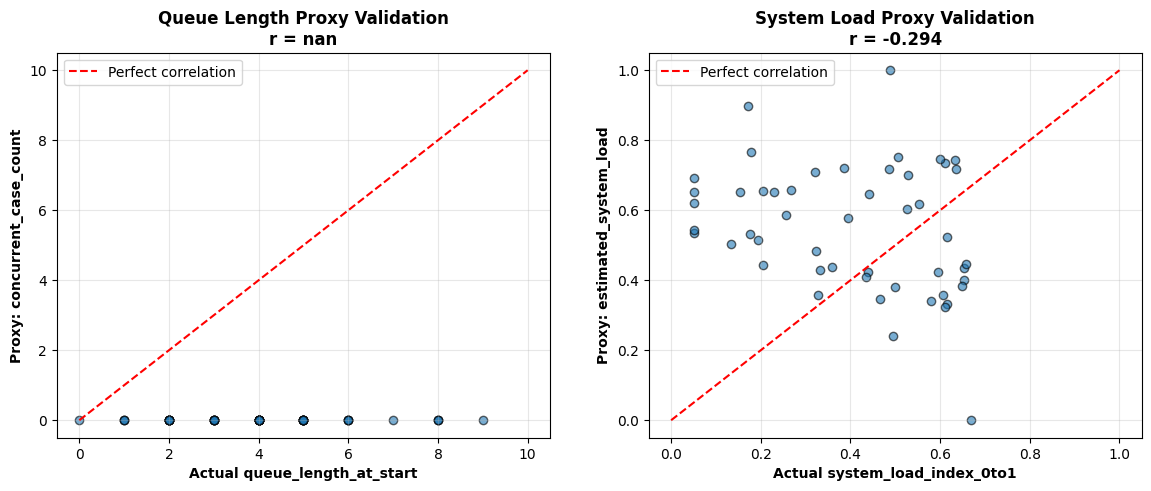

In [6]:
# Create proxies for 5k using same logic
clean_5kp_with_proxies = clean_5kp.copy()

# For 5k, we need timestamps for concurrent case calculation
# Use start_timestamp_utc
clean_5kp_with_proxies = clean_5kp_with_proxies.rename(columns={'start_timestamp_utc': 'timestamp'})

# Calculate proxy for queue length
clean_5kp_with_proxies = calculate_concurrent_cases(clean_5kp_with_proxies)

# Calculate proxy for system load
clean_5kp_with_proxies = calculate_system_load_proxy(clean_5kp_with_proxies)

# Rename back
clean_5kp_with_proxies = clean_5kp_with_proxies.rename(columns={'timestamp': 'start_timestamp_utc'})

# Now correlate proxies with actual values
print("\nValidating Proxies in 5k Dataset:")
# Queue length correlation
corr_queue, p_queue = stats.pearsonr(
    clean_5kp_with_proxies['queue_length_at_start'].dropna(),
    clean_5kp_with_proxies['concurrent_case_count'].dropna()
)

print(f"\nQueue Length Proxy:")
print(f"  Actual (queue_length_at_start) mean: {clean_5kp_with_proxies['queue_length_at_start'].mean():.2f}")
print(f"  Proxy (concurrent_case_count) mean:  {clean_5kp_with_proxies['concurrent_case_count'].mean():.2f}")
print(f"  Correlation: r = {corr_queue:.3f}, p = {p_queue:.4f}")

# System load correlation
corr_load, p_load = stats.pearsonr(
    clean_5kp_with_proxies['system_load_index_0to1'].dropna(),
    clean_5kp_with_proxies['estimated_system_load'].dropna()
)

print(f"\nSystem Load Proxy:")
print(f"  Actual (system_load_index) mean: {clean_5kp_with_proxies['system_load_index_0to1'].mean():.3f}")
print(f"  Proxy (estimated_system_load) mean: {clean_5kp_with_proxies['estimated_system_load'].mean():.3f}")
print(f"  Correlation: r = {corr_load:.3f}, p = {p_load:.4f}")

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Queue length scatter
axes[0].scatter(
    clean_5kp_with_proxies['queue_length_at_start'],
    clean_5kp_with_proxies['concurrent_case_count'],
    alpha=0.6, edgecolor='black'
)
axes[0].plot([0, 10], [0, 10], 'r--', label='Perfect correlation')
axes[0].set_xlabel('Actual queue_length_at_start', fontweight='bold')
axes[0].set_ylabel('Proxy: concurrent_case_count', fontweight='bold')
axes[0].set_title(f'Queue Length Proxy Validation\nr = {corr_queue:.3f}', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# System load scatter
axes[1].scatter(
    clean_5kp_with_proxies['system_load_index_0to1'],
    clean_5kp_with_proxies['estimated_system_load'],
    alpha=0.6, edgecolor='black'
)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect correlation')
axes[1].set_xlabel('Actual system_load_index_0to1', fontweight='bold')
axes[1].set_ylabel('Proxy: estimated_system_load', fontweight='bold')
axes[1].set_title(f'System Load Proxy Validation\nr = {corr_load:.3f}', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Create Model Ready Datasets

In [7]:
modeling_features = [
    # Core features (THE BIG ONES)
    'variance_to_expected',      # 10x lift
    'duration_minutes',           # 2.07x lift
    'wait_time_minutes',          # 1.65x lift
    
    # Queue/Load features
    'queue_length_at_start',      # 1.46x lift (5k only, use proxy for 2k)
    'system_load_index_0to1',     # 1.18x lift (5k only, use proxy for 2k)
    
    # Process features
    'handoff_count_so_far',       # 0.97x lift (weak but available)
    
    # Temporal features
    'weekday',
    'hour_of_day',
    
    # Business context
    'priority',
    'sla_breached',
]

print("\nModeling features defined:")
for i, feat in enumerate(modeling_features, 1):
    print(f"  {i:2d}. {feat}")

# For 2k, map proxy features
modeling_features_2k = [
    'variance_to_expected',
    'duration_minutes',
    'wait_time_minutes',
    'concurrent_case_count',       # PROXY for queue_length
    'estimated_system_load',       # PROXY for system_load
    'handoff_count_so_far',
    'weekday',
    'hour_of_day',
    'priority',
    'sla_breached',
]

# Save complete processed 2k
df_2k_processed.to_csv(processed_data_path/'2k_processed.csv', index=False)
print(f"\nSaved: data/processed/2k_processed.csv ({df_2k_processed.shape})")

# Save 5k with proxies (for validation)
clean_5kp_with_proxies.to_csv(processed_data_path/'5k_with_proxies.csv', index=False)
print(f"Saved: data/processed/5k_with_proxies.csv ({clean_5kp_with_proxies.shape})")


Modeling features defined:
   1. variance_to_expected
   2. duration_minutes
   3. wait_time_minutes
   4. queue_length_at_start
   5. system_load_index_0to1
   6. handoff_count_so_far
   7. weekday
   8. hour_of_day
   9. priority
  10. sla_breached

Saved: data/processed/2k_processed.csv ((2000, 29))
Saved: data/processed/5k_with_proxies.csv ((50, 33))


# SUMMARY

ACHIEVEMENTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- Standardized 2k features to match 5k structure
- Converted units (seconds → minutes)
- Calculated handoff_count_so_far for 2k
- Created hybrid expected_duration lookup (reference + data-driven)
- Calculated variance_to_expected (10x feature!) for 2k
- Engineered proxy features:
   - concurrent_case_count (queue proxy)
   - estimated_system_load (load proxy)
- Validated proxies on 5k:
   - Queue proxy correlation: r = {corr_queue:.3f}
   - System load proxy correlation: r = {corr_load:.3f}


ACTIVITY MISMATCH SOLUTION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
- Matched activities (3): Use reference table expectations
Unmatched activities (5): Use data-driven median expectations
   - Classify Request, Enrich Data, Manual Approval, Fulfill Request, Notify Customer


DATASETS READY FOR MODELING:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
data/processed/5k_with_proxies.csv - For training & proxy validation
data/processed/2k_processed.csv - For prediction & business validation
data/processed/expected_duration_lookup.csv - Reference for new data


FEATURE SET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
10 modeling features ready:
  1. variance_to_expected (10x lift) ***
  2. duration_minutes (2.07x lift) *
  3. wait_time_minutes (1.65x lift) *
  4. queue_length / concurrent_case_count (1.46x lift) **
  5. system_load / estimated_system_load (1.18x lift)
  6. handoff_count_so_far
  7-10. weekday, hour_of_day, priority, sla_breached